In [77]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import root_mean_squared_log_error
from sklearn.metrics import r2_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

In [78]:
data = pd.read_csv('../cleaned_dataset_without_na.csv', delimiter='|')
data.head()

,title,area,number_of_rooms,floor,type_of_market,parking,elevator,year_of_creation,internet,type_of_building,basement,price_for_m2_in_PLN,balcony,garden,terrace,street,district,city,latitude,longtitude
0,"Apartament inwestycyjny, ostatnie piętro, k/Sk...",24.89,1.0,4-7,secondary,0,1,2022.0,1.0,Apartment,0.0,16749.98,0,0,0,śląska 12,przymorze,gdansk,54.406171,18.576846
1,Apartament inwestycyjny Śląska 12 z umową najmu!,25.72,1.0,0,secondary,0,1,2022.0,1.0,Apartment,0.0,18500.00,0,0,0,śląska 12,przymorze,gdansk,54.406171,18.576846
2,"Nowe mieszkanie, wykończone - Mariana Kołodzieja",34.38,2.0,1-3,secondary,1,1,2022.0,1.0,Apartment,0.0,15997.67,1,0,0,mariana kołodzieja,ujeścisko-łostowice,gdansk,54.334542,18.585750
3,"Wyjątkowe mieszkanie w centrum Gdyni, blisko l...",101.58,4.0,4-7,secondary,0,1,1997.0,1.0,Apartment,0.0,11468.79,0,0,0,janusza korczaka,redłowo,gdynia,54.494118,18.543134
4,Mieszkanie w świetnej lokalizacji Gdynia Dąbrowa,68.00,3.0,1-3,secondary,0,0,2000.0,1.0,Apartment,1.0,10279.41,1,0,0,oliwkowa,dąbrowa,gdynia,54.471180,18.470508


In [79]:
data = data.drop('title', axis=1)
threshold_low = 5000  # Set your threshold value here
threshold_high = 30000
data = data[data['price_for_m2_in_PLN'] >= threshold_low]
data = data[data['price_for_m2_in_PLN'] <= threshold_high]


In [80]:
#data = data.drop('latitude', axis=1)
#data = data.drop('longtitude', axis=1)

In [81]:
data_numerical = data.drop(['city', 'district', 'type_of_market', 'type_of_building', 'floor', 'street'], axis=1)

In [82]:
# concatenating the city and district columns
data['city_district'] = data['city'] + '_' + data['district']

In [83]:
# save the dataset to a new csv file
data.to_csv('../propertyApp/cleaned_district_changed.csv', sep='|', index=False, header=True)

In [84]:
# saving the number of occurences of each district in the dataset to a dictionary
districts = data['city_district'].value_counts().to_dict()
# replacing the district names with the number of occurences
data['city_district'] = data['city_district'].map(districts)

In [85]:
data = data.drop(['city', 'district'], axis=1)

In [86]:
data.head()

,area,number_of_rooms,floor,type_of_market,parking,elevator,year_of_creation,internet,type_of_building,basement,price_for_m2_in_PLN,balcony,garden,terrace,street,latitude,longtitude,city_district
0,24.89,1.0,4-7,secondary,0,1,2022.0,1.0,Apartment,0.0,16749.98,0,0,0,śląska 12,54.406171,18.576846,400
1,25.72,1.0,0,secondary,0,1,2022.0,1.0,Apartment,0.0,18500.00,0,0,0,śląska 12,54.406171,18.576846,400
2,34.38,2.0,1-3,secondary,1,1,2022.0,1.0,Apartment,0.0,15997.67,1,0,0,mariana kołodzieja,54.334542,18.585750,715
3,101.58,4.0,4-7,secondary,0,1,1997.0,1.0,Apartment,0.0,11468.79,0,0,0,janusza korczaka,54.494118,18.543134,124
4,68.00,3.0,1-3,secondary,0,0,2000.0,1.0,Apartment,1.0,10279.41,1,0,0,oliwkowa,54.471180,18.470508,2663


In [87]:
A = data.drop(['price_for_m2_in_PLN', 'street'], axis=1)
b = data['price_for_m2_in_PLN']
X_train, X_test, y_train, y_test = train_test_split(A, b, test_size=0.2, random_state=0)

In [88]:
num_pipeline = make_pipeline(StandardScaler())
cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))
preprocessor = ColumnTransformer([("cat", cat_pipeline, make_column_selector(dtype_include=object)),], remainder=num_pipeline)
preprocessor = preprocessor.fit(X_train, y_train)
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [89]:
joblib.dump(preprocessor, '../propertyApp/preprocessor.pkl') 

['../propertyApp/preprocessor.pkl']

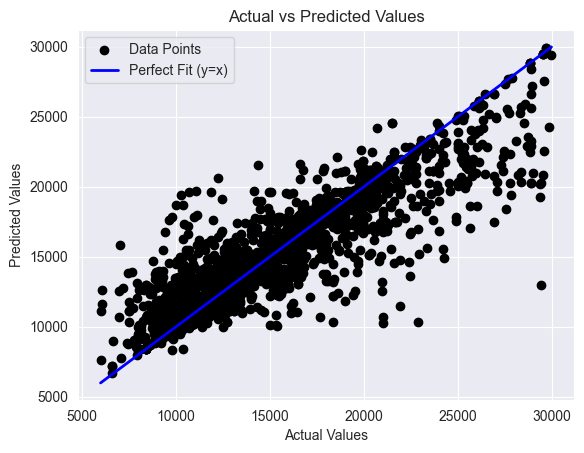

In [90]:
from sklearn.ensemble import RandomForestRegressor
RF_model = RandomForestRegressor(min_samples_split=2, n_estimators=800, max_features='sqrt', min_weight_fraction_leaf=0.0)
RF_model.fit(X_train_preprocessed, y_train)
y_pred_RF = RF_model.predict(X_test_preprocessed)
# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred_RF, color="black", label="Data Points")
x = np.linspace(min(y_test), max(y_test), 100)
plt.plot(x, x, color="blue", linewidth=2, label="Perfect Fit (y=x)")

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')

# Display legend
plt.legend()

# Show the plot
plt.show()

In [91]:
rmse_RF = root_mean_squared_error(y_test, y_pred_RF)
rmse_RF

np.float64(2274.916012296408)

In [92]:
r2_rf = r2_score(y_test, y_pred_RF)
r2_rf

0.7779709541550712

In [93]:
import numpy as np

# Retrieve feature importance scores
feature_importances = RF_model.feature_importances_


# Get feature names after transformation
feature_names = (
    preprocessor.named_transformers_['cat'][-1].get_feature_names_out(X_train.select_dtypes(include=object).columns)
    if 'cat' in preprocessor.named_transformers_
    else []
)
numeric_features = X_train.select_dtypes(exclude=object).columns
all_features = np.concatenate([numeric_features, feature_names])

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importance
print(feature_importance_df[feature_importance_df['Feature'] == 'latitude'])
print(feature_importance_df[feature_importance_df['Feature'] == 'longtitude'])


     Feature  Importance
10  latitude    0.019323
       Feature  Importance
11  longtitude    0.029864


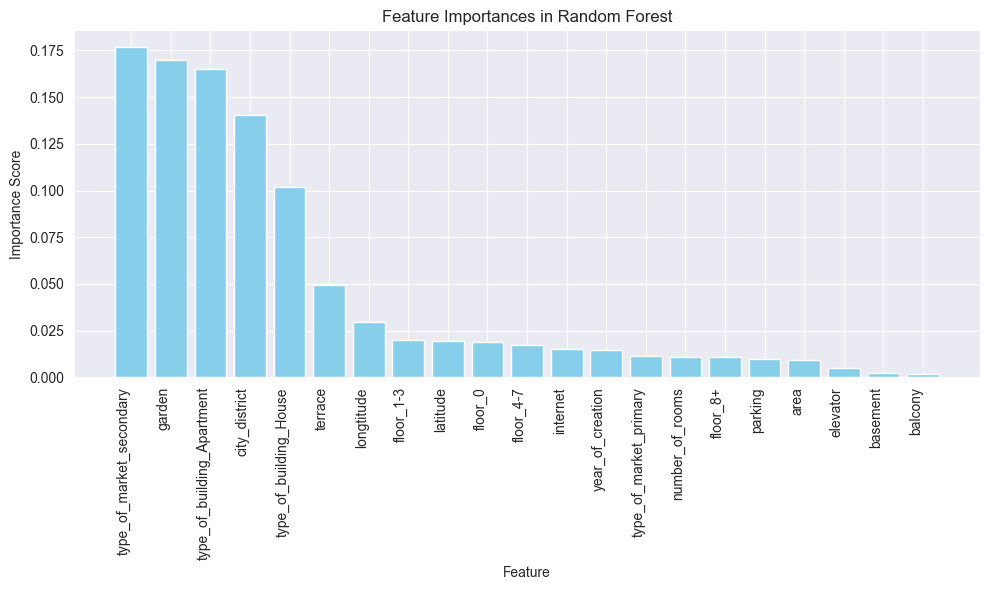

In [94]:
import matplotlib.pyplot as plt



# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('Feature Importances in Random Forest')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()


In [95]:
import joblib

# Save the model to a file
joblib.dump(RF_model, '../propertyApp/random_forest_model.pkl')

['../propertyApp/random_forest_model.pkl']

In [96]:
randomforest = joblib.load('../propertyApp/random_forest_model.pkl')

In [97]:
row = X_test.iloc[[0]]
row

,area,number_of_rooms,floor,type_of_market,parking,elevator,year_of_creation,internet,type_of_building,basement,balcony,garden,terrace,latitude,longtitude,city_district
1575,70.14,3.0,1-3,secondary,0,1,2020.0,0.0,Apartment,0.0,0,0,0,54.490386,18.423491,194


In [98]:
row_preprocessed = preprocessor.transform(row)

In [99]:
row_preprocessed

array([[ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  1.        ,  0.        ,  0.46544785,  0.35026902,
        -1.230844  ,  0.90801327,  0.54669575, -0.87961083, -0.75232781,
        -1.22614859, -0.38554519, -0.31495136,  0.3886627 , -0.21813504,
        -0.69243588]])

In [100]:
randomforest.predict(row_preprocessed)

array([12218.88729774])

In [101]:
row_preprocessed.toarray()

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'